In [1]:


import kagglehub
fantacher_neu_metal_surface_defects_data_path = kagglehub.dataset_download('fantacher/neu-metal-surface-defects-data')

print('Data source import complete.')


Using Colab cache for faster access to the 'neu-metal-surface-defects-data' dataset.
Data source import complete.


In [2]:
import kagglehub
import os
import shutil

# Download the dataset
print("Downloading NEU Metal Surface Defects Dataset...")
fantacher_neu_metal_surface_defects_data_path = kagglehub.dataset_download('fantacher/neu-metal-surface-defects-data')
print('✓ Dataset downloaded successfully')
print(f"Dataset location: {fantacher_neu_metal_surface_defects_data_path}")

# Define defect categories based on NEU dataset naming convention
DEFECT_CLASSES = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

def get_defect_class(filename):
    """Extract defect class from filename based on NEU dataset naming convention"""
    filename = os.path.basename(filename).lower()
    if 'cr_' in filename or 'crazing' in filename:
        return 'Crazing'
    elif 'in_' in filename or 'inclusion' in filename:
        return 'Inclusion'
    elif 'pa_' in filename or 'patches' in filename:
        return 'Patches'
    elif 'ps_' in filename or 'pitted' in filename:
        return 'Pitted'
    elif 'rs_' in filename or 'rolled' in filename:
        return 'Rolled'
    elif 'sc_' in filename or 'scratches' in filename:
        return 'Scratches'
    return None

# Create organized directory structure in Colab
base_organized_dir = '/content/neu_organized'
train_dir = os.path.join(base_organized_dir, 'train')
test_dir = os.path.join(base_organized_dir, 'test')
val_dir = os.path.join(base_organized_dir, 'valid')

# Create class subdirectories for train/test/valid
for split_dir in [train_dir, test_dir, val_dir]:
    for class_name in DEFECT_CLASSES:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

print("\n✓ Created organized directory structure")

# Find all images in the downloaded dataset
print("\nScanning for images in downloaded dataset...")
all_images = []
for root, dirs, files in os.walk(fantacher_neu_metal_surface_defects_data_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            all_images.append(os.path.join(root, file))

print(f"Found {len(all_images)} total images")

# Organize images by class
class_images = {class_name: [] for class_name in DEFECT_CLASSES}
unclassified = []

for img_path in all_images:
    class_name = get_defect_class(img_path)
    if class_name:
        class_images[class_name].append(img_path)
    else:
        unclassified.append(img_path)

# Display class distribution
print("\nClass distribution in source dataset:")
for class_name, images in class_images.items():
    print(f"  {class_name:12s}: {len(images):4d} images")

if unclassified:
    print(f"\nWarning: {len(unclassified)} unclassified images found")
    print("Sample unclassified filenames:")
    for img in unclassified[:5]:
        print(f"  - {os.path.basename(img)}")

# Split and copy images (70% train, 15% val, 15% test)
from sklearn.model_selection import train_test_split

print("\nSplitting dataset (70% train, 15% validation, 15% test)...")

for class_name, images in class_images.items():
    # First split: 70% train, 30% temp (for val+test)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=42)

    # Second split: Split the 30% into 15% val and 15% test
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=42)

    # Copy train images
    for img_path in train_imgs:
        dest = os.path.join(train_dir, class_name, os.path.basename(img_path))
        shutil.copy2(img_path, dest)

    # Copy validation images
    for img_path in val_imgs:
        dest = os.path.join(val_dir, class_name, os.path.basename(img_path))
        shutil.copy2(img_path, dest)

    # Copy test images
    for img_path in test_imgs:
        dest = os.path.join(test_dir, class_name, os.path.basename(img_path))
        shutil.copy2(img_path, dest)

    print(f"  {class_name:12s}: {len(train_imgs):3d} train | {len(val_imgs):3d} val | {len(test_imgs):3d} test")

print("\n" + "="*70)
print("✓ Dataset organization complete!")
print("="*70)
print(f"\nOrganized dataset location: {base_organized_dir}")
print(f"  Train directory: {train_dir}")
print(f"  Validation directory: {val_dir}")
print(f"  Test directory: {test_dir}")

# Verify the organization
print("\nVerifying directory structure...")
for split_name, split_dir in [('Train', train_dir), ('Validation', val_dir), ('Test', test_dir)]:
    total_images = sum([len(os.listdir(os.path.join(split_dir, cls))) for cls in DEFECT_CLASSES])
    print(f"  {split_name:12s}: {total_images} images across {len(DEFECT_CLASSES)} classes")

Using Colab cache for faster access to the 'neu-metal-surface-defects-data' dataset.
✓ Dataset downloaded successfully
Dataset location: /kaggle/input/neu-metal-surface-defects-data

✓ Created organized directory structure

Scanning for images in downloaded dataset...
Found 1800 total images

Class distribution in source dataset:
  Crazing     :  300 images
  Inclusion   :  300 images
  Patches     :  300 images
  Pitted      :  300 images
  Rolled      :  300 images
  Scratches   :  300 images

Splitting dataset (70% train, 15% validation, 15% test)...
  Crazing     : 210 train |  45 val |  45 test
  Inclusion   : 210 train |  45 val |  45 test
  Patches     : 210 train |  45 val |  45 test
  Pitted      : 210 train |  45 val |  45 test
  Rolled      : 210 train |  45 val |  45 test
  Scratches   : 210 train |  45 val |  45 test

✓ Dataset organization complete!

Organized dataset location: /content/neu_organized
  Train directory: /content/neu_organized/train
  Validation directory: 

In [3]:
#!pip install tensorflow
#!pip install matplotlib

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import os
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [5]:
for dirname, _, filenames in os.walk(r"F:\Thesis\archive\NEU Metal Surface Defects Data"):
    for filename in filenames:
        print(os.path.join(dirname,filename))

In [6]:
train_dir = os.path.join(base_organized_dir, 'train')
test_dir = os.path.join(base_organized_dir, 'test')
val_dir = os.path.join(base_organized_dir, 'valid')

print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Train directory: /content/neu_organized/train
Validation directory: /content/neu_organized/valid
Test directory: /content/neu_organized/test


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_val_datagen = ImageDataGenerator(rescale=1./255)



In [8]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=True)
val_generator = test_val_datagen.flow_from_directory(val_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=False)
test_generator = test_val_datagen.flow_from_directory(test_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=False)


Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [9]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 6)


In [10]:
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())
print(class_names_list)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


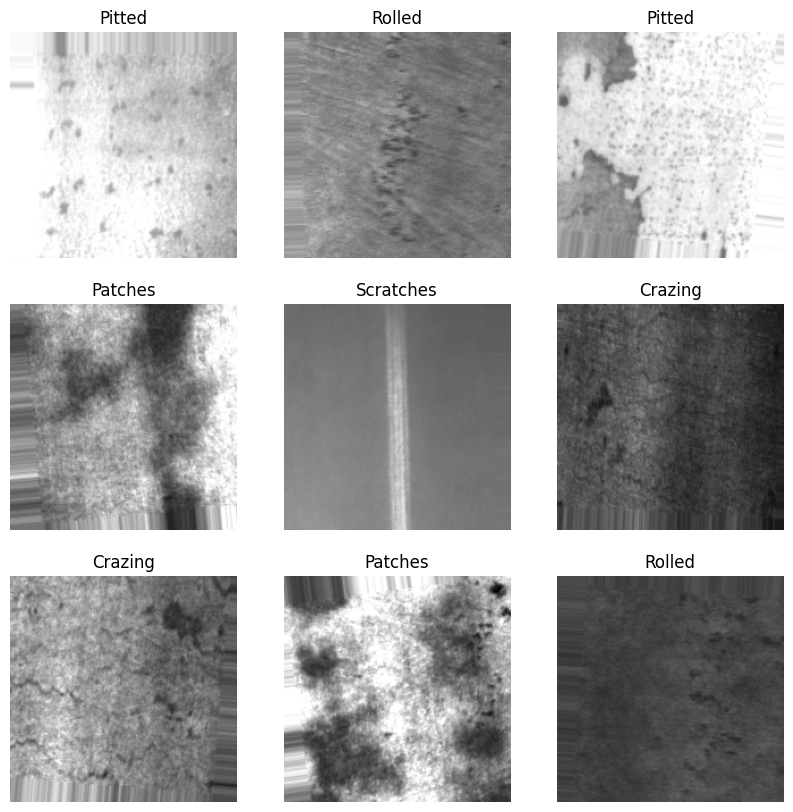

In [11]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names_list[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

sample_images(train_generator, nrows=3, ncols=3)


In [12]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

In [13]:
def load_model_1():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')])

    return model

In [ ]:
optimizer = Adam(learning_rate=1e-4)
lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
lr_scheduler_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

cnn_model = load_model_1()
cnn_model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

history_model1 = cnn_model.fit(
                        train_generator,
                        epochs=30,
                        validation_data=val_generator,
                        callbacks= [
                            #lr_scheduler_acc,
                            lr_scheduler_loss
                        ])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 444ms/step - accuracy: 0.3992 - loss: 1.6430 - val_accuracy: 0.1667 - val_loss: 2.3939 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.7423 - loss: 0.6847 - val_accuracy: 0.1667 - val_loss: 2.8769 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8347 - loss: 0.4406
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.8351 - loss: 0.4400 - val_accuracy: 0.3370 - val_loss: 2.4989 - learning_rate: 0.0010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.8406 - loss: 0.4092 - val_accuracy: 0.7074 - val_loss: 0.6469 - learning_rate: 1.0000e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.9151 - loss: 0.2668 - val_accuracy: 0.7148 - val_loss: 0.6759 - learning_rate: 1.0000e-04
Epoch 6/30
24/40 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8963 - lo

In [ ]:
result = cnn_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)
print("Test accuracy:", result[1])

plot_history(history_model1,"accuracy")
plot_history(history_model1,"loss")

In [ ]:
# Get model predictions
pred_probs_cnn = cnn_model.predict(test_generator)
pred_labels = np.argmax(pred_probs_cnn, axis=1)

# Get true labels
true_labels = test_generator.classes


In [ ]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optional: class names (from generator)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Baseline CNN Model")
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_probs = cnn_model.predict(test_generator)
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Binarize the labels for multi-class ROC curve
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle='--', linewidth=2)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CNN Model (Multi-class)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("\n===== ROC AUC Scores per Class =====")
for i in range(n_classes):
    print(f"{class_names[i]:12s}: {roc_auc[i]:.4f}")
print(f"\nMicro-average: {roc_auc['micro']:.4f}")

In [ ]:
# Check this from your existing plots
print(f"Final Training Accuracy: {history_model1.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_model1.history['val_accuracy'][-1]:.4f}")
print(f"Final Test Accuracy: {result[1]:.4f}")

In [ ]:
cnn_model.save("cnn_model1.h5")

In [ ]:
# Predict probabilities
y_prob = cnn_model.predict(test_generator)

# Get true labels
y_true = test_generator.classes

# Get predicted class labels
y_pred = np.argmax(y_prob, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro average for multi-class, or use 'binary' for binary classification)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Classification Report
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(y_true, y_pred))

In [ ]:
print("\n===== FINAL DATASET SUMMARY =====")
print("Training images:", train_generator.n)
print("Validation images:", val_generator.n)
print("Testing images:", test_generator.n)
print("\nClass mapping:", train_generator.class_indices)
